In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install grad-cam
!pip install ttach

# Importing Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

import os, time, copy, random, imutils, itertools, sys
import json
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import gridspec

import random
import seaborn as sns
from sklearn.utils import shuffle

import cv2
from cv2 import cv2
from google.colab.patches import cv2_imshow

import tqdm
import torchvision
from torchvision import models, transforms
from torchvision.models import vgg16, vgg19,resnet50, resnet18, wide_resnet101_2, resnext50_32x4d, densenet121, inception_v3
from torchvision.datasets import imagenet
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from grad_cam import GradCam, GuidedBackpropReLUModel, show_cams, show_gbs, preprocess_image, deprocess_image
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch.autograd import Function


%matplotlib inline

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model = vgg19(pretrained=True)
model.to(device)
model = model.eval()
num_ftrs = model.classifier[0].in_features
print(num_ftrs)

25088


In [ ]:
# print(v_model._modules.keys())

In [ ]:
# v_model

In [ ]:
# for param_tensor in reversed(v_model.state_dict()):
#     print(param_tensor, "\t", v_model.state_dict()[param_tensor].size())

In [ ]:
# model = inception_v3(pretrained=True)
# model.to(device)
# model = model.eval()
# num_ftrs = model.fc.in_features
# print(num_ftrs)

In [ ]:
print(model._modules.keys())

odict_keys(['features', 'avgpool', 'classifier'])


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Playing Around With EfficientNet

In [ ]:
for param_tensor in reversed(model.state_dict()):
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

classifier.6.bias 	 torch.Size([1000])
classifier.6.weight 	 torch.Size([1000, 4096])
classifier.3.bias 	 torch.Size([4096])
classifier.3.weight 	 torch.Size([4096, 4096])
classifier.0.bias 	 torch.Size([4096])
classifier.0.weight 	 torch.Size([4096, 25088])
features.34.bias 	 torch.Size([512])
features.34.weight 	 torch.Size([512, 512, 3, 3])
features.32.bias 	 torch.Size([512])
features.32.weight 	 torch.Size([512, 512, 3, 3])
features.30.bias 	 torch.Size([512])
features.30.weight 	 torch.Size([512, 512, 3, 3])
features.28.bias 	 torch.Size([512])
features.28.weight 	 torch.Size([512, 512, 3, 3])
features.25.bias 	 torch.Size([512])
features.25.weight 	 torch.Size([512, 512, 3, 3])
features.23.bias 	 torch.Size([512])
features.23.weight 	 torch.Size([512, 512, 3, 3])
features.21.bias 	 torch.Size([512])
features.21.weight 	 torch.Size([512, 512, 3, 3])
features.19.bias 	 torch.Size([512])
features.19.weight 	 torch.Size([512, 256, 3, 3])
features.16.bias 	 torch.Size([256])
features

In [ ]:
param_tensor = 'classifier.6.weight'
print(param_tensor, "\n", model.state_dict()[param_tensor])
y = model.state_dict()
y[param_tensor] = torch.rand(y[param_tensor].shape)
print(param_tensor, "\n", y[param_tensor])

classifier.6.weight 
 tensor([[ 0.0098,  0.0138, -0.0005,  ...,  0.0163,  0.0025, -0.0105],
        [-0.0165,  0.0079, -0.0165,  ...,  0.0350, -0.0258, -0.0043],
        [-0.0237, -0.0072,  0.0151,  ...,  0.0098, -0.0066, -0.0122],
        ...,
        [-0.0133,  0.0418,  0.0055,  ..., -0.0028, -0.0198, -0.0092],
        [ 0.0065,  0.0271, -0.0101,  ..., -0.0117, -0.0187,  0.0022],
        [ 0.0048,  0.0041,  0.0271,  ...,  0.0238, -0.0119,  0.0081]],
       device='cuda:0')
classifier.6.weight 
 tensor([[0.5807, 0.1103, 0.4364,  ..., 0.8175, 0.0669, 0.7382],
        [0.6393, 0.4654, 0.0576,  ..., 0.8687, 0.0929, 0.0352],
        [0.2383, 0.1963, 0.7526,  ..., 0.9742, 0.1198, 0.1972],
        ...,
        [0.8764, 0.4846, 0.8743,  ..., 0.2188, 0.1850, 0.3664],
        [0.0729, 0.8180, 0.1770,  ..., 0.8969, 0.0704, 0.0762],
        [0.9169, 0.3206, 0.7082,  ..., 0.0233, 0.6852, 0.4577]])


In [ ]:
y =torch.rand(2,3)
z = torch.rand(y.shape)
print(z.shape)

torch.Size([2, 3])


In [ ]:
# Preprocess image
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.open('img.jpg')).unsqueeze(0)
img = img.cuda()
print(img.shape) # torch.Size([1, 3, 224, 224])

# Opening JSON file
f = open("imagenet_class_index.json",)
class_idx = json.load(f)
labels = [class_idx[str(k)][1] for k in range(len(class_idx))]

# Classify
model.eval()
with torch.no_grad():
    outputs = model(img)

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[idx], p=prob*100))
    print(idx)

torch.Size([1, 3, 224, 254])
-----
giant_panda                                                                 (100.00%)
388
skunk                                                                       (0.00%)
361
French_bulldog                                                              (0.00%)
245
lesser_panda                                                                (0.00%)
387
soccer_ball                                                                 (0.00%)
805


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#It's EfficientNet things
# ... image preprocessing as in the classification example ...
# print(img.shape) # torch.Size([1, 3, 224, 224])

# features = model.extract_features(img)
# print(features.shape) # torch.Size([1, 1280, 7, 7])

# Save And Load From checkpoint

In [ ]:
def save_checkpoint(model, checkpoint_path):
    torch.save(model.state_dict(), checkpoint_path)
    return model

def load_checkpoint(model, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        model = model.to(device)
        model.eval()
        print("=> loaded checkpoint '{}'".format(checkpoint_path))
    else: 
        print("=> no checkpoint found at '{}'".format(checkpoint_path))
        return

    return model

# Some Image Processing Methods

In [ ]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        #CHANGE THIS!!
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        #CHANGE THIS!!
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

def load_images(image_paths, path_flag = 1):
    images = []
    raw_images = []
    if path_flag:
      print("Images:")
      for i, image_path in enumerate(image_paths):
          print("\t#{}: {}".format(i, image_path))
          image, raw_image = preprocess(image_path)
          images.append(image)
          raw_images.append(raw_image)
      return images, raw_images
    else:
      print("Images:")
      # for image_path in image_paths:
      #     # print("\t#{}: {}".format(i, image_path))
      image, raw_image = preprocess(image_paths, path_flag)
      images.append(image)
      raw_images.append(raw_image)
      return images, raw_images


def get_classtable():
    classes = []
    with open("samples/synset_words.txt") as lines:
        for line in lines:
            line = line.strip().split(" ", 1)[1]
            line = line.split(", ", 1)[0].replace(" ", "_")
            classes.append(line)
    return classes


def preprocess(image_path, path_flag = 1):
    if path_flag:
      raw_image = cv2.imread(image_path)
    else:
      raw_image = image_path
    try:
      raw_image = cv2.resize(raw_image, (255,) * 2)
    except Exception as e:
      print(str(e))
    
    
    img_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    image = img_transform(raw_image)
    if path_flag:
      raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    return image, raw_image

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

# Visualization Techniques

(224, 224, 3)
(3, 224, 224)


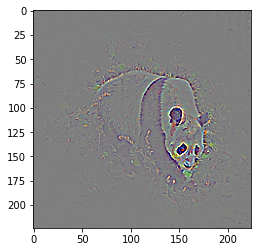

(224, 224, 3)


In [ ]:
img = cv2.imread('img.jpg', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
print(img.shape)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
gb_model = GuidedBackpropReLUModel(model=copy.deepcopy(model), activation_layer_name = 'ReLU', use_cuda=True)
gb = gb_model(inputs, index=target_index)
print(gb.shape)
gb = gb.transpose((1, 2, 0))
gb = deprocess_image(gb)
plt.imshow(gb)
plt.show()
print(gb.shape)

# Old Methods

In [ ]:
# def visualize_with_all_technique(image_paths):
#   grayscale_saliency_list = []
#   input_saliency_list = []
#   target_layer = model._blocks[-1]
#   # print("target layer:", target_layer)

#   target_category = None
#   images, raw_images = load_images(image_paths)
#   images = torch.stack(images).to(device)
#   rgb_img = raw_images[0].astype('float32')/np.max(raw_images[0])
#   original_img = images[0].cpu()
#   grayscale_saliency_list.append(original_img)
#   print(original_img.shape)
#   # If target_category is None, the highest scoring category
#   # will be used for every image in the batch.
#   # target_category can also be an integer, or a list oflippedimage= cv2.flip(image, 1)f different integers
#   # for every image in the batch.
#   # gradient = pytorch_grad_camFullGrad(model=model, target_layer=target_layer, use_cuda=True)
#   # grayscale_gradient = gradient(input_tensor=images, target_category=target_category)
#   # visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_gradient)
#   # grayscale_saliency_list.append(grayscale_gradient)
#   # input_saliency_list.append(visualization)

#   gradcam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
#   # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   grayscale_gradcam = gradcam(input_tensor=images, target_category=target_category)
#   # grayscale_gradcam = grayscale_gradcam[0, :]
#   # visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_gradcam)
#   grayscale_saliency_list.append(grayscale_gradcam)
#   print(grayscale_gradcam.shape)
#   # input_saliency_list.append(visualization)

#   # gradcam_pp = GradCAMPlusPlus(model=model, target_layer=target_layer, use_cuda=True)
#   # grayscale_gradcam_pp = gradcam_pp(input_tensor=images, target_category=target_category)
#   # # grayscale_gradcam_pp = grayscale_gradcam_pp[0, :]
#   # # visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_gradcam_pp)
#   # grayscale_saliency_list.append(grayscale_gradcam_pp)
#   # # input_saliency_list.append(visualization)

#   # scorecam = ScoreCAM(model=model, target_layer=target_layer, use_cuda=True)
#   # grayscale_scorecam = scorecam(input_tensor=images, target_category=target_category)
#   # visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_scorecam)
#   # grayscale_saliency_list.append(grayscale_scorecam)
#   # input_saliency_list.append(visualization)
#   del images, raw_images, rgb_img, gradcam
#   return grayscale_saliency_list, input_saliency_list


In [ ]:
# def plot_all_techniques_visualizations(grayscale_saliency_list):
#   cmap= 'gray'
#   fig = plt.figure(figsize=(6,6))
#   rows = len(grayscale_saliency_list[0])
#   columns = len(grayscale_saliency_list)
#   print('columns= ', columns)
#   print('rows= ', rows)
#   # plot_single_img(img)
#   # titles = ['GB', 'Grad-CAM', 'Guided Grad-CAM']
#   titles = ['Input', 'Grad-CAM']

#   # ax enables access to manipulate each of subplots
#   ax = []
#   for i in range(columns):
#       img = grayscale_saliency_list[i]
#       img = img[0, :]
#       ax.append( fig.add_subplot(rows, columns, i+1) )
#       ax[-1].set_title(titles[i])  # set title
#       ax[-1].axis('off')
#       plt.imshow(img)
#   plt.show()
#   del ax, fig

# New Methods

In [ ]:
# def visualize_with_all_technique(image_paths):
#   grayscale_saliency_list = []
#   input_saliency_list = []
#   target_layer = model._blocks[-1]
#   # print("target layer:", target_layer)
#   grad_cam_for_bp = GradCam(model=copy.deepcopy(model), blob_name = '_blocks', target_layer_names=['1','15', '54'], use_cuda=True)
#   img = cv2.imread('img.jpg', 1)
#   img = np.float32(cv2.resize(img, (224, 224))) / 255
#   inputs = preprocess_image(img)
#   # If None, returns the map for the highest scoring category.
#   # Otherwise, targets the requested index.
#   target_index = None
#   mask_dic = grad_cam_for_bp(inputs, target_index)
#   cam, cam_mask = show_cams(img, mask_dic)
#   gb_model = GuidedBackpropReLUModel(model=copy.deepcopy(model), activation_layer_name = 'MemoryEfficientSwish', use_cuda=True)
#   gb, cam_gb = show_gbs(inputs, gb_model, target_index, mask_dic)
#   cam_mask = np.expand_dims(cam_mask, axis=2)
#   print('multiplying gb by cam:')
#   print('gb image:', gb)
#   print('cam_mask image:', cam_mask)
#   cam_gb = deprocess_image(np.multiply(gb, cam_mask))
#   cam_mask = deprocess_image(cam_mask)
#   # cam_gb = np.multiply(gb, cam_mask)
#   print('gb * cam_mask: ', cam_gb)
#   img = np.expand_dims(img, axis=0)
#   gb = np.expand_dims(gb, axis=0)
#   cam = np.expand_dims(cam, axis=0)
#   cam_gb = np.expand_dims(cam_gb, axis=0)
#   cam_mask = cam_mask.transpose(2,0,1)
#   # cam = np.expand_dims(cam, axis=0)
#   grayscale_saliency_list.append(img)
#   grayscale_saliency_list.append(gb)
#   print('cam_mask image:', cam_mask.shape)
#   grayscale_saliency_list.append(cam_mask)
#   # print('cam image:', cam)
#   grayscale_saliency_list.append(cam_gb)
#   # print('cam_gb image:', cam_gb)
#   return grayscale_saliency_list, input_saliency_list

In [ ]:
# def plot_all_techniques_visualizations(grayscale_saliency_list):
#   cmap= 'bwr'
#   fig = plt.figure(figsize=(6,6))
#   rows = len(grayscale_saliency_list[0])
#   columns = len(grayscale_saliency_list)
#   print('columns= ', columns)
#   print('rows= ', rows)
#   # plot_single_img(img)
#   # titles = ['GB', 'Grad-CAM', 'Guided Grad-CAM']
#   titles = ['Input','Guided BP',  'Grad-CAM', 'Guided Grad-CAM']

#   # ax enables access to manipulate each of subplots
#   ax = []
#   for i in range(columns):
#       img = grayscale_saliency_list[i]
#       img = img[0, :]
#       print(titles[i] + ' shape: ' + str(img.shape))
#       ax.append( fig.add_subplot(rows, columns, i+1) )
#       ax[-1].set_title(titles[i])  # set title
#       ax[-1].axis('off')
#       plt.imshow(img)
#   plt.show()
#   # del ax, fig

# Merging Both Together

In [ ]:
def visualize_with_all_technique(image_paths):
  grayscale_saliency_list = []
  input_saliency_list = []
  # target_layer = model._blocks[-1]
  # # print("target layer:", target_layer)

  target_category = None
  images, raw_images = load_images(image_paths)
  images = torch.stack(images).to(device)
  rgb_img = raw_images[0].astype('float32')/np.max(raw_images[0])
  original_img = images[0].cpu()

  # gradcam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
  # img = cv2.imread(image_paths[0], 1)
  # img = np.float32(cv2.resize(img, (224, 224))) / 255
  # inputs = preprocess_image(img)
  # grayscale_gradcam = gradcam(input_tensor=images, target_category=target_category)
  # # visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_gradcam)
  # del images, raw_images, rgb_img, gradcam
  # grayscale_gradcam = deprocess_image(grayscale_gradcam)
  # input_saliency_list.append(visualization)
  grad_cam_for_bp = GradCam(model=copy.deepcopy(model), blob_name = 'features', target_layer_names=['35'], use_cuda=True)
  mask_dic = grad_cam_for_bp(inputs, target_index)
  cam, cam_mask = show_cams(img, mask_dic)
  gb_model = GuidedBackpropReLUModel(model=copy.deepcopy(model), activation_layer_name = 'ReLU', use_cuda=True)
  gb, cam_gb = show_gbs(inputs, gb_model, target_index, mask_dic)
  cam_mask = np.expand_dims(cam_mask, axis=2)
  # grayscale_gradcam = grayscale_gradcam.transpose((1, 2, 0))
  # print('multiplying gb by cam:')
  # print('gb image:', gb.shape)
  # print('cam_mask image:', grayscale_gradcam.shape)
  # cam_gb = deprocess_image(np.multiply(gb, grayscale_gradcam))
  # # grayscale_gradcam = deprocess_image(grayscale_gradcam)
  # print('gb * cam_mask: ', cam_gb.shape)
  # grayscale_gradcam = grayscale_gradcam.transpose((2, 0, 1))
  cam_mask = cam_mask.transpose((2, 0, 1))
  gb = gb.transpose((2, 0, 1))
  grayscale_saliency_list.append(original_img)
  grayscale_saliency_list.append(gb)
  grayscale_saliency_list.append(cam_mask)
  # grayscale_saliency_list.append(grayscale_gradcam)
  # grayscale_saliency_list.append(cam_gb)
  del grad_cam_for_bp, cam
  return grayscale_saliency_list, input_saliency_list


In [ ]:
def plot_all_techniques_visualizations(grayscale_saliency_list):
  cmap= 'bwr'
  fig = plt.figure(figsize=(6,6))
  rows = len(grayscale_saliency_list[0])
  columns = len(grayscale_saliency_list)
  print('columns= ', columns)
  print('rows= ', rows)
  # plot_single_img(img)
  # titles = ['GB', 'Grad-CAM', 'Guided Grad-CAM']
  titles = ['Input','Guided BP',  'Grad-CAM', 'Grad-CAM_diff package']

  # ax enables access to manipulate each of subplots
  ax = []
  for i in range(columns):
      img = grayscale_saliency_list[i]
      img = img[0, :]
      print(titles[i] + ' shape: ' + str(img.shape))
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title(titles[i])  # set title
      ax[-1].axis('off')
      plt.imshow(img)
  plt.show()
  # del ax, fig

In [ ]:
grayscale_saliency_list, input_saliency_list = visualize_with_all_technique(image_paths = ['img.jpg'])

Images:
	#0: img.jpg


columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


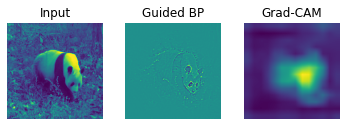

In [ ]:
plot_all_techniques_visualizations(grayscale_saliency_list)

# Model Preprocessing

In [ ]:
layer_randomization_order = ['classifier.6', 'classifier.3', 'classifier.0',
                             'features.34', 'features.32', 'features.30', 'features.28', 
                             'features.25', 'features.23', 'features.21', 'features.19', 
                             'features.16', 'features.14', 'features.12', 'features.10', 
                             'features.7', 'features.5', 'features.2', 'features.0']
original_checkpoint_path = "./models/vgg19_original_checkpoint.pth"
save_checkpoint(model, original_checkpoint_path)
checkpoint_path = "./models/vgg19_last_cascading_checkpoint.pth"
save_checkpoint(model, checkpoint_path)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Cascading Randomization

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Cascading reinitialization up to on layer classifier.6 i =  0
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


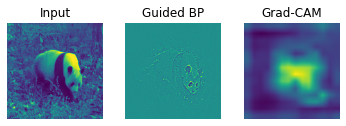

Cascading reinitialization up to on layer classifier.3 i =  1
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


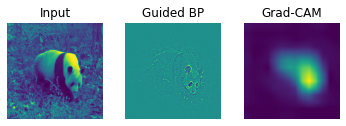

Cascading reinitialization up to on layer classifier.0 i =  2
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


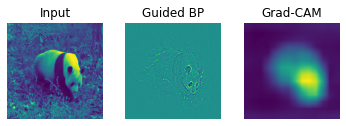

Cascading reinitialization up to on layer features.34 i =  3
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


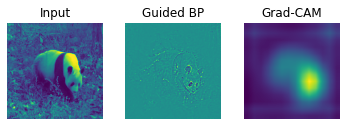

Cascading reinitialization up to on layer features.32 i =  4
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


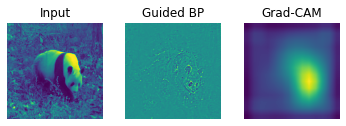

Cascading reinitialization up to on layer features.30 i =  5
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


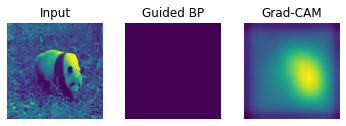

Cascading reinitialization up to on layer features.28 i =  6
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


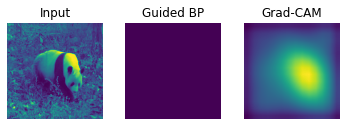

Cascading reinitialization up to on layer features.25 i =  7
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


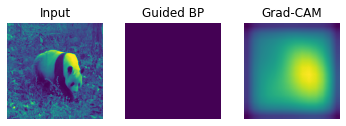

Cascading reinitialization up to on layer features.23 i =  8
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


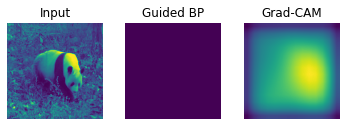

Cascading reinitialization up to on layer features.21 i =  9
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


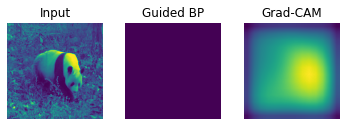

Cascading reinitialization up to on layer features.19 i =  10
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


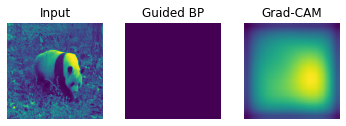

Cascading reinitialization up to on layer features.16 i =  11
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


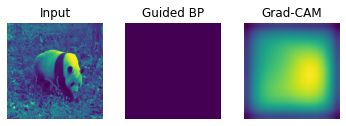

Cascading reinitialization up to on layer features.14 i =  12
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg


/content/drive/MyDrive/GradCAM_pytorch/grad_cam.py:104: RuntimeWarning: overflow encountered in multiply
  cam += w * target[i, :, :]
/content/drive/MyDrive/GradCAM_pytorch/grad_cam.py:104: RuntimeWarning: overflow encountered in add
  cam += w * target[i, :, :]


columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


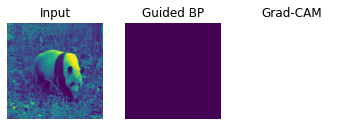

Cascading reinitialization up to on layer features.12 i =  13
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


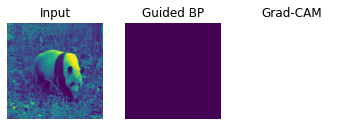

Cascading reinitialization up to on layer features.10 i =  14
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


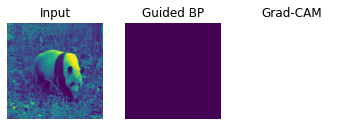

Cascading reinitialization up to on layer features.7 i =  15
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


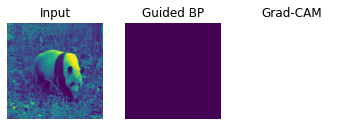

Cascading reinitialization up to on layer features.5 i =  16
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


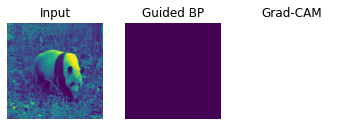

Cascading reinitialization up to on layer features.2 i =  17
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


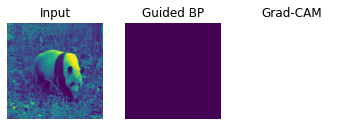

Cascading reinitialization up to on layer features.0 i =  18
=> loaded checkpoint './models/vgg19_last_cascading_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


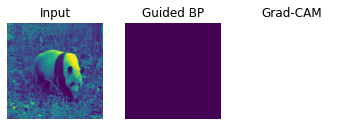

In [ ]:
load_checkpoint(model, original_checkpoint_path)
# begin randomization
for i, layer_name in enumerate(layer_randomization_order):
  print("Cascading reinitialization up to on layer {}".format(layer_name), 'i = ', i)
  new_state_dict = model.state_dict()
  new_state_dict[layer_name+'.weight'] = torch.rand(model.state_dict()[layer_name+'.weight'].shape)
      
  torch.save(new_state_dict, checkpoint_path)
  # del new_state_dict
  load_checkpoint(model, checkpoint_path)
  grayscale_saliency_list, input_saliency_list = visualize_with_all_technique(image_paths = ['img.jpg'])
  plot_all_techniques_visualizations(grayscale_saliency_list)
  # break
  # del grayscale_saliency_list, input_saliency_list

# Independent Randomization

In [ ]:
load_checkpoint(model, original_checkpoint_path)
checkpoint_path = "./models/vgg19_last_independent_checkpoint.pth"
save_checkpoint(model, checkpoint_path)

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer classifier.6 i =  0
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


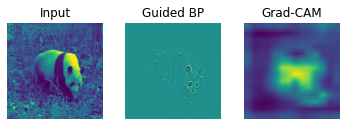

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer classifier.3 i =  1
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


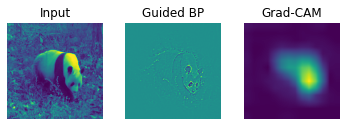

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer classifier.0 i =  2
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


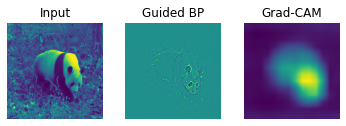

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.34 i =  3
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


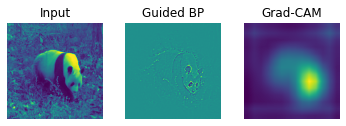

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.32 i =  4
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


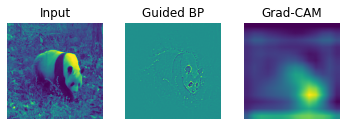

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.30 i =  5
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


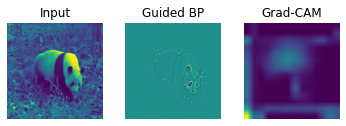

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.28 i =  6
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


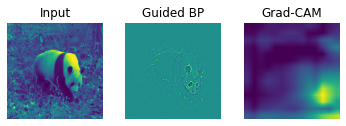

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.25 i =  7
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


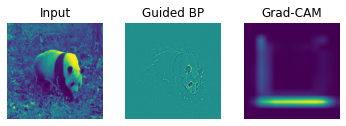

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.23 i =  8
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


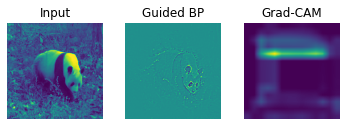

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.21 i =  9
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


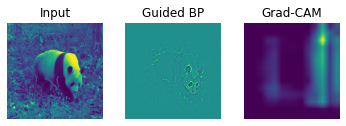

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.19 i =  10
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


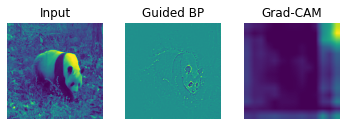

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.16 i =  11
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


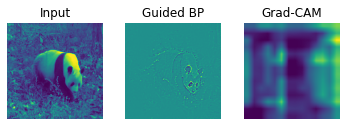

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.14 i =  12
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


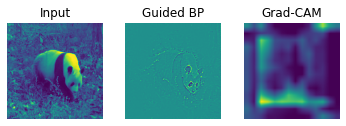

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.12 i =  13
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


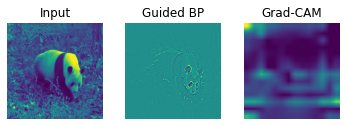

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.10 i =  14
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


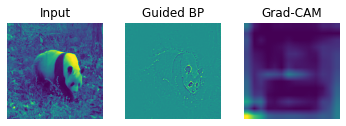

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.7 i =  15
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


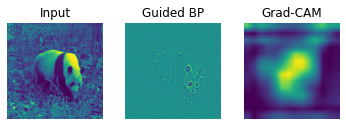

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.5 i =  16
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


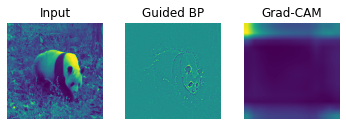

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.2 i =  17
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


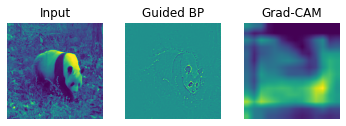

=> loaded checkpoint './models/vgg19_original_checkpoint.pth'
Independnet reinitialization up to on layer features.0 i =  18
=> loaded checkpoint './models/vgg19_last_independent_checkpoint.pth'
Images:
	#0: img.jpg
columns=  3
rows=  3
Input shape: torch.Size([224, 224])
Guided BP shape: (224, 224)
Grad-CAM shape: (224, 224)


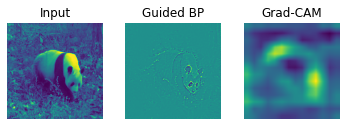

In [ ]:
# begin randomization
for i, layer_name in enumerate(layer_randomization_order):
  #This line is the only difference
  load_checkpoint(model, original_checkpoint_path)
  print("Independnet reinitialization up to on layer {}".format(layer_name), 'i = ', i)
  new_state_dict = model.state_dict()
  new_state_dict[layer_name+'.weight'] = torch.rand(model.state_dict()[layer_name+'.weight'].shape)
  torch.save(new_state_dict, checkpoint_path)
  # del new_state_dict
  load_checkpoint(model, checkpoint_path)
  grayscale_saliency_list, input_saliency_list = visualize_with_all_technique(image_paths = ['img.jpg'])
  plot_all_techniques_visualizations(grayscale_saliency_list)
  # del grayscale_saliency_list, input_saliency_list